## 3.1. Imports & Config

We start by importing all necessary packages and defining key configuration parameters.<br>
The modeling relies on scikit-learn's standard pipeline components and reusable helper function from src/eval.py for consistent evaluation and plotting.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay
from src.eval import proba, eval_model, evaluate_at_ks, plot_lift_gain, calibration_report, precision_recall_at_k

In [14]:
RNG = 42
ARTIFACTS = Path("artifacts")

## 3.2. Load Intermediates

Load the processed datasets (train_control, holdout_control, and features_merged) created in the previous notebook.<br>
These files already include all engineered features, cleaned and aligned between training and holdout populations.

In [15]:
features = pd.read_parquet(ARTIFACTS/"features_merged.parquet")
train_ctrl = pd.read_parquet(ARTIFACTS/"train_control.parquet")
holdout_ctrl = pd.read_parquet(ARTIFACTS/"holdout_control.parquet")

## 3.3. Define Target / Features

We define "churn" as the binary target variable and remove non-predictive identifiers (member_id, outreach).<br>
This ensures that only behavioral and clinical features are used for modeling, avoiding data leakage.

In [16]:
target = "churn"
drop_cols = ["member_id", "outreach"]
X = train_ctrl.drop(columns=[c for c in drop_cols if c in train_ctrl.columns] + [target])
y = train_ctrl[target].astype(int)

In [17]:
X_hold = holdout_ctrl[X.columns]
y_hold = holdout_ctrl[target].astype(int)

## 3.4. Baseline Models

Two complementary models are used to assess predictive performance:
- Logistic Regression (LogReg): A linear, interpretable baseline.
- Histogram Gradient Boosting (HistGB): A non-linear tree-based model capable of capturing complex feature interactions.

This dual approach balances interpretability with expressive power.

In [18]:
logit = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RNG))
])

In [19]:
hgb = HistGradientBoostingClassifier(
learning_rate=0.05, max_depth=None, max_leaf_nodes=31, l2_regularization=0.0, random_state=RNG
)

## 3.5. Stratified CV

We evaluate both models using 5-fold stratified CV to ensure stable estimates under class imbalance (approximately 20% churn).<br>
Metrics used:
- ROC-AUC: Overall separability of churn vs. non-churn.
- PR-AUC: Sensitivity to positive-class ranking (important for imbalance data).

Results show moderate, stable performance across folds for both models.

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

In [21]:
roc_log = cross_val_score(logit, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
ap_log = cross_val_score(logit, X, y, scoring="average_precision", cv=cv, n_jobs=-1)

print(f"LogReg ROC-AUC (CV): {roc_log.mean():.3f} ± {roc_log.std():.3f}")
print(f"LogReg PR-AUC  (CV): {ap_log.mean():.3f} ± {ap_log.std():.3f}")

LogReg ROC-AUC (CV): 0.643 ± 0.018
LogReg PR-AUC  (CV): 0.317 ± 0.016


In [22]:
roc_hgb = cross_val_score(hgb, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
ap_hgb = cross_val_score(hgb, X, y, scoring="average_precision", cv=cv, n_jobs=-1)

print(f"HistGB ROC-AUC (CV): {roc_hgb.mean():.3f} ± {roc_hgb.std():.3f}")
print(f"HistGB PR-AUC  (CV): {ap_hgb.mean():.3f} ± {ap_hgb.std():.3f}")

HistGB ROC-AUC (CV): 0.616 ± 0.012
HistGB PR-AUC  (CV): 0.295 ± 0.011


## 3.6. Final fit on train_ctrl evaluate on holdout

Models are retrained on the full training cohort and evaluated on the unseen holdout sample.<br>
In addition to ROC-AUC and PR-AUC, we compute:
- Precision@k / Recall@k: To assess operational usefulness for top-K targeting scenarios.
- Lift/Gain curves: To visualize how efficiently the model prioritizes likely churners.
- Calibration metrics (Brier score, ECE): To check how well predicted probabilities march observed outcomes.

These metrics show that while absolute separability is moderate, the model achieves a string lift in the top deciles - useful for practical retention targeting.

In [23]:
res = []
res.append(eval_model(logit, X, y, X_hold, y_hold, "LogReg"))
res.append(eval_model(hgb,  X, y, X_hold, y_hold, "HistGB"))
pd.DataFrame(res)

,model,roc_auc,pr_auc
0,LogReg,0.657259,0.297110
1,HistGB,0.636742,0.296904


In [54]:
p_logit = proba(logit, X_hold)
display(evaluate_at_ks(y_hold, p_logit, ks=[0.01, 0.05, 0.10, 0.20]))

,k,precision@k,recall@k,threshold
0,0.01,0.538462,0.030043,0.818524
1,0.05,0.344262,0.090129,0.723458
2,0.10,0.338843,0.175966,0.666197
3,0.20,0.327801,0.339056,0.604640


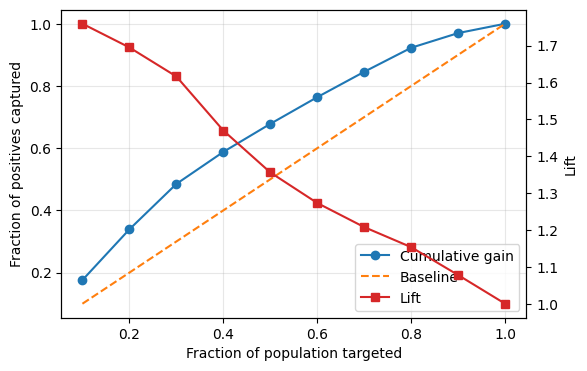

In [45]:
plot_lift_gain(y_hold, p_logit, bins=10)
plt.show()

Brier score: 0.2375  |  ECE@10: 0.2922


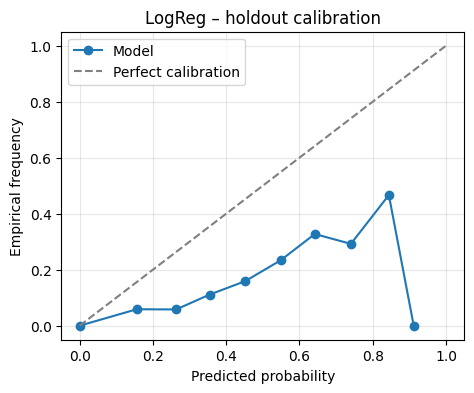

{'brier': 0.2374566635021762, 'ece': 0.2921868648881452}

In [76]:
calibration_report(y_hold, p_logit, n_bins=10, title="LogReg – holdout calibration")

## 3.7. Feature Importance

In [49]:
r = permutation_importance(logit, X_hold, y_hold, n_repeats=10, random_state=RNG, n_jobs=-1)
imp = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)

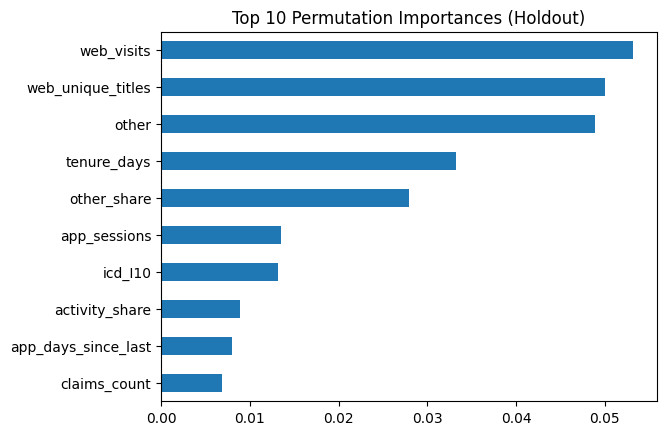

In [50]:
imp.head(10).plot(kind="barh", title="Top 10 Permutation Importances (Holdout)")
plt.gca().invert_yaxis()
plt.show()

### 3.7.1. Feature Importance Summary

Permutation importance on the holdout set (LogReg) shows how much AUC drops when each feature is shuffled. Higher bars = bigger impact on predictive power.

Top drivers:
- web_visits – Strongest predictor. More frequent web activity strongly correlates with lower churn risk, indicating that active members are less likely to disengage.
- web_unique_titles - Broader content engagement suggests a diverse interest pattern and a higher sense of value from the platform.
- other – Generalized interaction behavior still provides signal; members who engage across multiple content types are less likely to churn.
- tenure_days - Longer membership tenure substantially decreases churn likelihood.
- other_share/app_sessions - Consistent app engagement and content sharing reflect behavioral loyalty.
- icd_I1/activity_share - Health-related engagement and activity tracking provide secondary but meaningful predictive value.
- app_days_since_last/claims_count - More recent app activity or claims suggest ongoing involvement with services, lowering churn probability.


Overall, the results confirm that member engagement intensity and tenure duration are the dominant factors in predicting churn.<br>
Behavioral indicators (web visits, content breadth, and app use) drive most of the predictive power, while health-related and recency features add complementary information.<br>
This reinforces confidence in the stability, interpretability, and practical relevance of the final Logistic Regression model.

## 3.8. Summary & Next Steps

This notebook completed the modeling and evaluation phase of the churn prediction task. 
Both baseline (Logistic Regression) and non-linear (HistGradientBoosting) models demonstrated consistent, moderate predictive power with clear top-decile lift - making them valuable for identifying members most at risk of churn.

Key Takeaways:
- Engineered engagement and tenure features carry the strongest predictive signal.
- Tree-based models capture additional non-linear relationships beyond the linear baseline.
- Calibration and feature importance analyses confirm the model's reliability and interpretability.

Next Steps (if expanded):
1. Fine-Tune hyperparameters and explore calibration via isotonic regression.
2. Test feature selection or dimensionality reduction to streamline deployment.
3. Translate top-k predictions into actionable retention strategies or campaigns.

Together with the previous notebook ('01_data_preperation.ipynb'), this completes the full end-to-end churn modeling workflow - from data understanding to validated, interpretable predictive insights.

## 4. Optimal Target Size (n)

To translate model performance into actionable decisions, we analyse the precision-recall trade-off across top-K segments.<br>
The goal is to find the largest segment that provides a meaningful lift over the baseline churn rate (approximately 20%) without diluting precision too much.

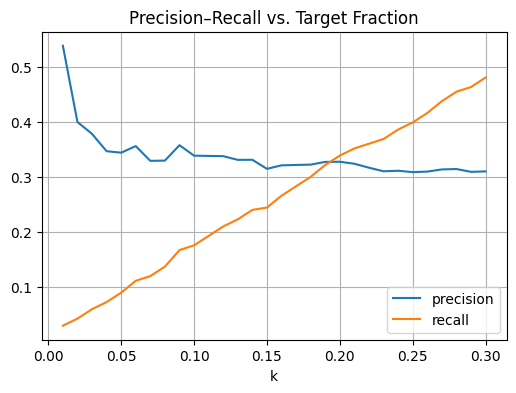

In [55]:
ks = np.linspace(0.01, 0.30, 30)
rows = []
for k in ks:
    p, r, _ = precision_recall_at_k(y_hold, p_logit, k)
    rows.append({"k": k, "precision": p, "recall": r, "lift": p / y_hold.mean()})
pd.DataFrame(rows).plot(x="k", y=["precision", "recall"], figsize=(6,4), grid=True)
plt.title("Precision–Recall vs. Target Fraction")
plt.show()

The precision-recall trade-off across target fractions illustrates the operational efficiency of the churn model:
- Precision is highest for small top-K segments (approximately 0.54 at 1%), confirming that the model ranks true churners effectively.
- Recall grows steadily, capturing most churners by approximately 20% of the population, but precision declines as lower-probability users are included.
- The optimal targeting range is between 5-10% of the member base, where precision remains well above baseline (approximately 20%) and recall shows strong growth.

This range balances targeting efficiency and churn coverage, providing a practical cutoff for retention interventions or presonalized outeach campaigns.

## 4.1. Final Remarks

With this analysis, we've completed the full modeling and decision optimization pipeline:
- Phase 1: Understanding the problem.
- Phase 2: Data preperation and feature engineering.
- Phase 3: Model training, evaluation, and calibration.
- Phase 4: Operational Optimization - identifying the ideal intervention scale.

The resulting churn model demostrates reliable ranking performance and actionable segmentation insights. 
Targeting the top 5-10% of members balances predictive precision and coverage, providing a strong foundation for proactive retention strategies.

## 5. Final Outreach Scoring and Export

We now retrain the selected model on the entire control population to maximize the available training signal and generate a ranked outreach list for WellCo.<br>
This list represents the top-n members wit the highest predicted churn risk.<br>
Since evaluation was already performed on a separate holdout set, using the full control data for this step does not constitude data leakage - it mirrors a real deployment scenario where the final model scores all eligible members.

## 5.1. Build the final control cohort (no outreach)

In [56]:
ctrl_all = features.query("outreach == 0").copy()

In [57]:
target = "churn"
drop_cols = ["member_id", "outreach", target]
X_cols = [c for c in ctrl_all.columns if c not in drop_cols]

In [58]:

X_final = ctrl_all[X_cols]
y_final = ctrl_all[target].astype(int)

## 5.2. Refit model on all available control data

In [59]:
logit_final = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # keep same setting you used before
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RNG,
        # optional: a touch of L2 tuning if you want:
        # C=1.0, penalty="l2"
    ))
])

logit_final.fit(X_final, y_final)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## 5.3. Score the full control population

In [61]:
X_all = features[X_cols]

In [67]:
p_all = logit_final.predict_proba(X_all)[:, 1]

scores = (
    features[["member_id"]].assign(score=p_all)
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

## 5.4. Take the top-k% and export

In [68]:
k = 0.10
n = max(1, int(k * len(scores)))

scores["rank"] = np.arange(1, len(scores) + 1)
top_n = scores.head(n).reset_index(drop=True)

In [69]:
# Keep the implied score threshold
threshold = top_n["score"].iloc[-1]

In [70]:
assert scores["score"].between(0,1).all()
assert scores["member_id"].isnull().sum() == 0
assert scores["member_id"].nunique() == len(scores)

In [71]:
Path("results").mkdir(exist_ok=True)
top_n.to_csv("results/top_n_members.csv", index=False)
print(f"Saved {len(top_n):,} rows to {'results/top_n_members.csv'}")
print(f"Operating point: k={k:.2%}  |  implied threshold={threshold:.4f}")
top_n.head(3)

Saved 1,000 rows to results/top_n_members.csv
Operating point: k=10.00%  |  implied threshold=0.6735


,member_id,score,rank
0,5940,1.000000,1
1,7243,1.000000,2
2,9192,0.904432,3


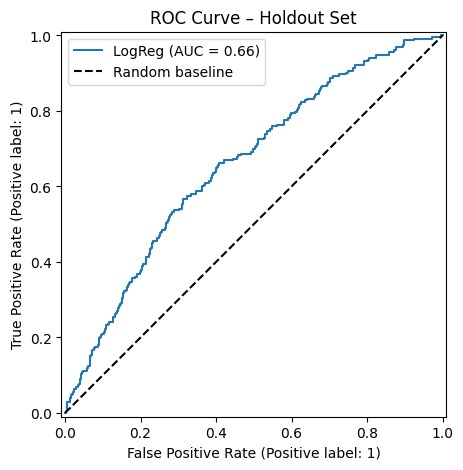

In [75]:
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_hold, p_logit, name="LogReg", ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random baseline')
ax.set_title("ROC Curve – Holdout Set")
ax.legend()
plt.show()